Conversion of python notebook in Julia

Original Notebook: https://www.kaggle.com/dlarionov/feature-engineering-xgboost

Original Author: Denis Larionov

This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

In [8]:
using DataFrames
using CSV
using Plots
import Seaborn
const sns = Seaborn
import PyPlot
const plt = PyPlot
using Statistics
using MLLabelUtils

┌ Info: Precompiling MLLabelUtils [66a33bbf-0c2b-5fc8-a008-9da813334f0a]
└ @ Base loading.jl:1186


In [3]:
items = CSV.read("input/items.csv", copycols=true)
shops = CSV.read("input/shops.csv", copycols=true)
cats  = CSV.read("input/item_categories.csv", copycols=true)
train = CSV.read("input/sales_train.csv", copycols=true)
test  = CSV.read("input/test.csv", copycols=true)

print("input loaded")

input loaded

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

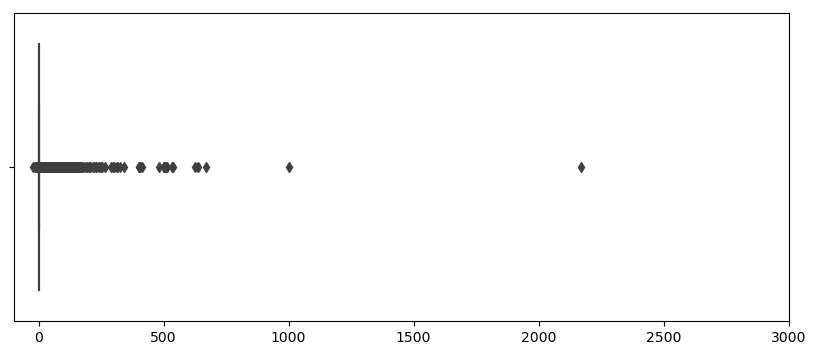

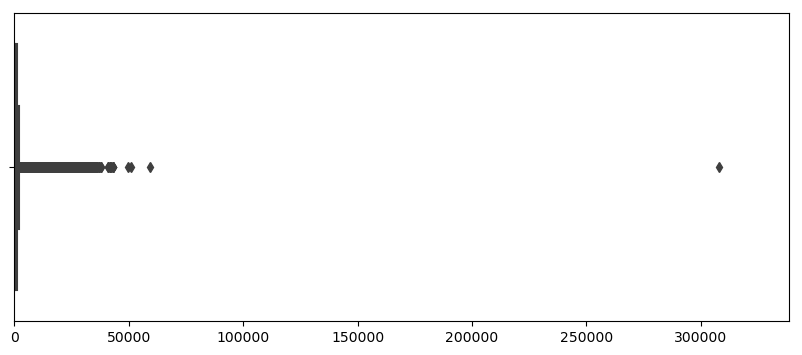

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7faebdd65860>

In [4]:
plt.figure(figsize=(10, 4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10, 4))
plt.xlim(minimum(train.item_price), maximum(train.item_price)*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_price.<100000, :]
train = train[train.item_cnt_day.<1001, :]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
,String,Int64,Int64,Int64,Float64,Float64
1,02.01.2013,0,59,22154,999.0,1.0
2,03.01.2013,0,25,2552,899.0,1.0
3,05.01.2013,0,25,2552,899.0,-1.0
4,06.01.2013,0,25,2554,1709.05,1.0
5,15.01.2013,0,25,2555,1099.0,1.0
6,10.01.2013,0,25,2564,349.0,1.0
7,02.01.2013,0,25,2565,549.0,1.0
8,04.01.2013,0,25,2572,239.0,1.0
9,11.01.2013,0,25,2572,299.0,1.0


There is one item with price below zero. Fill it with median.

In [6]:
median_item_price = median(train[(train.shop_id.==32).&(train.item_id.==2973).&(train.date_block_num.==4).&(train.item_price.>0), :].item_price);
train[train.item_price.<0, :item_price] = median_item_price

1874.0

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [7]:
# Якутск Орджоникидзе, 56
train[train.shop_id .== 0, :shop_id] = 57
test[test.shop_id .== 0, :shop_id] = 57
# Якутск ТЦ "Центральный"
train[train.shop_id .== 1, :shop_id] = 58
test[test.shop_id .== 1, :shop_id] = 58
# Жуковский ул. Чкалова 39м²
train[train.shop_id .== 10, :shop_id] = 11
test[test.shop_id .== 10, :shop_id] = 11

11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [30]:
shops[shops.shop_name .== "Сергиев Посад ТЦ \"7Я\"", :shop_name] = "СергиевПосад ТЦ \"7Я\""
shops[:city] = map(x -> split(x, " ")[1], shops[:shop_name])
shops[shops.city .== "!Якутск", :city] = "Якутск"
shops[:city_code] =  convertlabel(LabelEnc.Indices{Int}, shops.city) 
shops = shops[[:shop_id, :city_code]]

,shop_id,city_code
,Int64,Int64
1,0,1
2,1,1
3,2,2
4,3,3
5,4,4
6,5,5
7,6,6
8,7,6
9,8,6


In [ ]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)